In [1]:
import torch
import sys
sys.path.append("/home/kaliayev/Documents/recvis21_a3")

%load_ext autoreload
%autoreload 2

from torch import nn
from torchsummary import summary

# Data initialization and loading
from src.data import data_transforms
from torchvision import datasets

from PIL import Image
from torchvision import transforms

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from tqdm.notebook import tqdm_notebook

In [2]:
MODEL = torch.hub.load("facebookresearch/WSL-Images", "resnext101_32x48d_wsl")
BATCH_SIZE = 32
DATA_PATH = "../299_cropped_bird_dataset"
DATA_TRANSFORMS = transforms.Compose(
    [
        transforms.transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
EMBEDDINGS_PATH = "../embeddings"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using cache found in /home/kaliayev/.cache/torch/hub/facebookresearch_WSL-Images_main


## Extract embeddings for images using a model pretrained on COCO

In [3]:
def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])

model_conv_features = slice_model(MODEL, to_layer=-1).to(device)

# Get summary of the model
summary(model_conv_features, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5         [-1, 1536, 56, 56]          98,304
       BatchNorm2d-6         [-1, 1536, 56, 56]           3,072
              ReLU-7         [-1, 1536, 56, 56]               0
            Conv2d-8         [-1, 1536, 56, 56]         663,552
       BatchNorm2d-9         [-1, 1536, 56, 56]           3,072
             ReLU-10         [-1, 1536, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         393,216
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

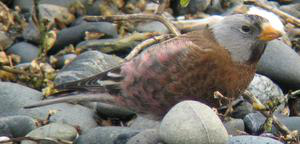

In [4]:
filename = "../299_cropped_bird_dataset/train_images/034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_Finch_0064_27007.jpg"
input_image = Image.open(filename)
input_image

In [5]:
# pre-processing required by ResNext
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


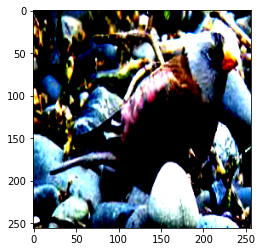

In [6]:
# Plotting the preprocessed picture to be usable by the model
# the range of values now fall outside the [0..1] RGB valid range
plt.imshow(np.moveaxis(input_tensor.numpy(), 0, -1 ))
plt.show()

In [7]:
input_batch = torch.stack([input_tensor])
input_batch = input_batch.to(device)

# applying the model to the pre-processed picture and extracting the 2048 ResNext features
with torch.no_grad():
    output = model_conv_features(input_batch).flatten(start_dim=1)
print('shape', output.shape)

shape torch.Size([1, 2048])


In [8]:
output

tensor([[0.7396, 0.8543, 0.8735,  ..., 0.5520, 0.8713, 0.9324]],
       device='cuda:0')

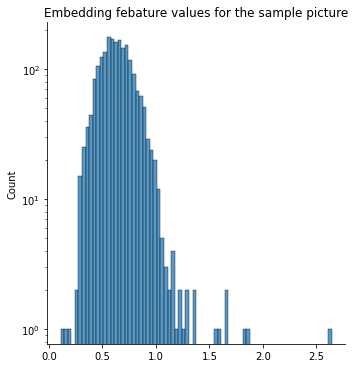

In [9]:
sns.displot(output[0].cpu().numpy())
# plt.xscale('log')
plt.yscale('log')
plt.title('Embedding febature values for the sample picture')
plt.show()

## Now that we've done it on a single image, let's do it on all the images

In [10]:
from src.FeatureExtractor import FeatureExtractor

feature_extractor = FeatureExtractor(
    model_name = "ResNext", 
    model_path = None,
    data_path = DATA_PATH, 
    dest_path = EMBEDDINGS_PATH, 
    batch_size = BATCH_SIZE, 
    data_transforms = DATA_TRANSFORMS, 
    device = "cpu",
)
feature_extractor.extract_features()

Using cache found in /home/kaliayev/.cache/torch/hub/facebookresearch_WSL-Images_main


Start working on:  train


  0%|                                                                                                                                                                                  | 0/34 [00:00<?, ?it/s]

torch.Size([32, 3, 299, 299])


  3%|█████                                                                                                                                                                     | 1/34 [00:29<16:01, 29.14s/it]

torch.Size([32, 3, 299, 299])


  6%|██████████                                                                                                                                                                | 2/34 [00:58<15:34, 29.21s/it]

torch.Size([32, 3, 299, 299])


  9%|███████████████                                                                                                                                                           | 3/34 [01:27<15:06, 29.24s/it]

torch.Size([32, 3, 299, 299])


 12%|████████████████████                                                                                                                                                      | 4/34 [01:56<14:37, 29.24s/it]

torch.Size([32, 3, 299, 299])


 15%|█████████████████████████                                                                                                                                                 | 5/34 [02:26<14:08, 29.25s/it]

torch.Size([32, 3, 299, 299])


 18%|██████████████████████████████                                                                                                                                            | 6/34 [02:55<13:39, 29.26s/it]

torch.Size([32, 3, 299, 299])


 21%|███████████████████████████████████                                                                                                                                       | 7/34 [03:24<13:09, 29.25s/it]

torch.Size([32, 3, 299, 299])


 24%|████████████████████████████████████████                                                                                                                                  | 8/34 [03:53<12:40, 29.27s/it]

torch.Size([32, 3, 299, 299])


 26%|█████████████████████████████████████████████                                                                                                                             | 9/34 [04:23<12:11, 29.25s/it]

torch.Size([32, 3, 299, 299])


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 10/34 [04:52<11:41, 29.24s/it]

torch.Size([32, 3, 299, 299])


 32%|██████████████████████████████████████████████████████▋                                                                                                                  | 11/34 [05:21<11:12, 29.24s/it]

torch.Size([32, 3, 299, 299])


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 12/34 [05:50<10:43, 29.26s/it]

torch.Size([32, 3, 299, 299])


 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 13/34 [06:20<10:14, 29.25s/it]

torch.Size([32, 3, 299, 299])


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 14/34 [06:49<09:45, 29.25s/it]

torch.Size([32, 3, 299, 299])


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 15/34 [07:18<09:15, 29.25s/it]

torch.Size([32, 3, 299, 299])


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 16/34 [07:47<08:46, 29.26s/it]

torch.Size([32, 3, 299, 299])


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 17/34 [08:17<08:17, 29.27s/it]

torch.Size([32, 3, 299, 299])


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 18/34 [08:46<07:48, 29.27s/it]

torch.Size([32, 3, 299, 299])


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 19/34 [09:15<07:19, 29.27s/it]

torch.Size([32, 3, 299, 299])


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 20/34 [09:45<06:50, 29.29s/it]

torch.Size([32, 3, 299, 299])


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 21/34 [10:14<06:20, 29.30s/it]

torch.Size([32, 3, 299, 299])


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 22/34 [10:43<05:51, 29.30s/it]

torch.Size([32, 3, 299, 299])


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 23/34 [11:13<05:22, 29.29s/it]

torch.Size([32, 3, 299, 299])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 24/34 [11:42<04:53, 29.31s/it]

torch.Size([32, 3, 299, 299])


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 25/34 [12:11<04:23, 29.30s/it]

torch.Size([32, 3, 299, 299])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 26/34 [12:40<03:54, 29.30s/it]

torch.Size([32, 3, 299, 299])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 27/34 [13:10<03:25, 29.29s/it]

torch.Size([32, 3, 299, 299])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 28/34 [13:39<02:55, 29.30s/it]

torch.Size([32, 3, 299, 299])


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 29/34 [14:08<02:26, 29.30s/it]

torch.Size([32, 3, 299, 299])


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 30/34 [14:38<01:57, 29.30s/it]

torch.Size([32, 3, 299, 299])


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 31/34 [15:07<01:27, 29.29s/it]

torch.Size([32, 3, 299, 299])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 32/34 [15:36<00:58, 29.29s/it]

torch.Size([32, 3, 299, 299])


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 33/34 [16:06<00:29, 29.30s/it]

torch.Size([26, 3, 299, 299])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [16:30<00:00, 29.12s/it]


Creating embeddings folder
Saving all features and labels for train
Saved 1082 features map and 1082 labels
Start working on:  val


  0%|                                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]

torch.Size([32, 3, 299, 299])


 25%|██████████████████████████████████████████▊                                                                                                                                | 1/4 [00:29<01:27, 29.29s/it]

torch.Size([32, 3, 299, 299])


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 2/4 [00:58<00:58, 29.29s/it]

torch.Size([32, 3, 299, 299])


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3/4 [01:27<00:29, 29.29s/it]

torch.Size([7, 3, 299, 299])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:34<00:00, 23.64s/it]


Saving all features and labels for val
Saved 103 features map and 103 labels
Start working on:  test


  0%|                                                                                                                                                                                  | 0/17 [00:00<?, ?it/s]

torch.Size([32, 3, 299, 299])


  6%|██████████                                                                                                                                                                | 1/17 [00:29<07:47, 29.24s/it]

torch.Size([32, 3, 299, 299])


 12%|████████████████████                                                                                                                                                      | 2/17 [00:58<07:19, 29.29s/it]

torch.Size([32, 3, 299, 299])


 18%|██████████████████████████████                                                                                                                                            | 3/17 [01:27<06:50, 29.31s/it]

torch.Size([32, 3, 299, 299])


 24%|████████████████████████████████████████                                                                                                                                  | 4/17 [01:57<06:20, 29.30s/it]

torch.Size([32, 3, 299, 299])


 29%|██████████████████████████████████████████████████                                                                                                                        | 5/17 [02:26<05:51, 29.29s/it]

torch.Size([32, 3, 299, 299])


 35%|████████████████████████████████████████████████████████████                                                                                                              | 6/17 [02:55<05:22, 29.31s/it]

torch.Size([32, 3, 299, 299])


 41%|██████████████████████████████████████████████████████████████████████                                                                                                    | 7/17 [03:25<04:53, 29.31s/it]

torch.Size([32, 3, 299, 299])


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                          | 8/17 [03:54<04:23, 29.30s/it]

torch.Size([32, 3, 299, 299])


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 9/17 [04:23<03:54, 29.30s/it]

torch.Size([32, 3, 299, 299])


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 10/17 [04:52<03:25, 29.30s/it]

torch.Size([32, 3, 299, 299])


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 11/17 [05:22<02:55, 29.30s/it]

torch.Size([32, 3, 299, 299])


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 12/17 [05:51<02:26, 29.32s/it]

torch.Size([32, 3, 299, 299])


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 13/17 [06:20<01:57, 29.31s/it]

torch.Size([32, 3, 299, 299])


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 14/17 [06:50<01:27, 29.29s/it]

torch.Size([32, 3, 299, 299])


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 15/17 [07:19<00:58, 29.31s/it]

torch.Size([32, 3, 299, 299])


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 16/17 [07:48<00:29, 29.28s/it]

torch.Size([5, 3, 299, 299])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [07:53<00:00, 27.86s/it]

Saving all features and labels for test
Saved 517 features map and 517 labels
